In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

## 0. Downloading the data and taking a look at it

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

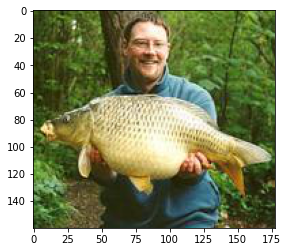

In [4]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [0]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [0]:
files = getListOfFiles(str(path))

In [0]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [0]:
class CustomDataset(Dataset):
    def __init__(self, files, window_size=30, tfms=None):
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        self.c = 3
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = io.imread(self.files[idx])
        if len(img.shape) < 3:
            aux = np.zeros(shape=(img.shape[0],img.shape[1],3), dtype=np.uint8)
            aux[:,:,0] = img
            aux[:,:,1] = img
            aux[:,:,2] = img
            img = aux

        if self.tfms:
            #try:
            img = self.tfms(Image.fromarray(img))
            #except:
            #    print(self.files[idx])
            #    print(img.shape)
            #    import pdb;pdb.set_trace()

        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[0,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.485)/0.229
        img_window[1,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.456)/0.224
        img_window[2,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.406)/0.225


        sample = (img_window,img)
        #sample = (img,img)
        
        return sample

In [0]:
tfms_train = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.75,1.25), contrast=(0.75,1.25), saturation=(0.5,1.25)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
tfms_valid = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
train_ds = CustomDataset(files_train,tfms=tfms_train,window_size=32)
valid_ds = CustomDataset(files_val,tfms=tfms_valid,window_size=32)

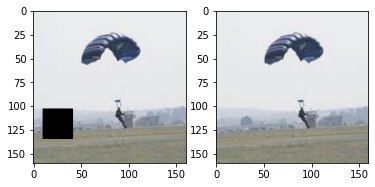

In [121]:
train_ds.show(0)

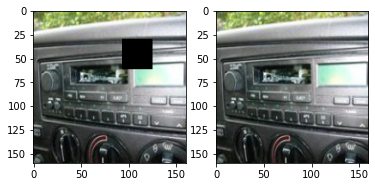

In [122]:
valid_ds.show(0)

In [0]:
train_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)

In [0]:
inputs, classes = next(iter(train_dl))

In [16]:
inputs.shape, classes.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 3, 160, 160]))

## 3. Creating the Databunch and Learner

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
encoder = models.resnet18(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-2])

model = DynamicUnet(encoder, n_classes=3, img_size=(160,160), blur=False, blur_final=True,
        self_attention=True, y_range=None, norm_type=None, last_cross=True,
        bottle=True)

learn = Learner(data,model,loss_func = nn.MSELoss())

#creates 3 groups: from beginning to m[0][6], from m[0][6] to m[1] and from m[1] to end
#m[1] to end is the decoder
def split_fn(m): return (m[0][6],m[1])

#creates the layer groups
learn.split(split_fn)

#I'll fit only the last layer group (the decoder) (and the batch norm layers)
learn.freeze()

#kaiming normal initialization
apply_init(learn.model[2], nn.init.kaiming_normal_)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 2.29E-03


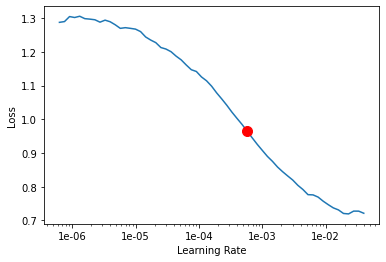

In [107]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [126]:
learn.fit_one_cycle(3, max_lr=slice(2e-3),
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')],)

epoch,train_loss,valid_loss,time
0,0.025688,0.020991,07:06
1,0.017894,0.018932,07:05
2,0.015905,0.015022,07:04


Better model found at epoch 0 with valid_loss value: 0.020991334691643715.
Better model found at epoch 1 with valid_loss value: 0.018932076171040535.
Better model found at epoch 2 with valid_loss value: 0.015022272244095802.


In [0]:
def show_results(learn,figsize=(5,5)):
    inputs,classes = next(iter(learn.data.valid_dl))
    learn.model.eval()
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
_ = learn.load('stage-1')

MSE: 34.079083949037994
PSNR: 8.74052268084153


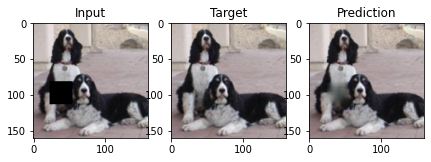

In [129]:
show_results(learn,figsize=(7,7))

MSE: 12.874239587175747
PSNR: 12.968185934272276


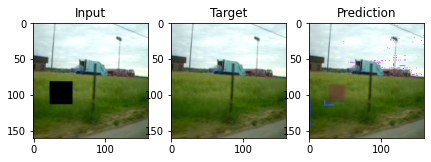

In [131]:
show_results(learn,figsize=(7,7))

MSE: 8.473972219034057
PSNR: 14.784531445523202


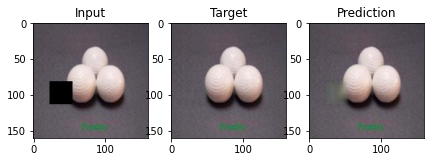

In [132]:
show_results(learn,figsize=(7,7))

MSE: 68.2045735418878
PSNR: 5.727266826483348


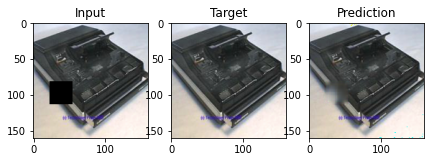

In [133]:
show_results(learn,figsize=(7,7))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


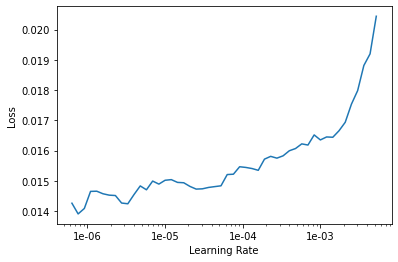

In [135]:
learn.lr_find()
learn.recorder.plot()

In [136]:
learn.fit_one_cycle(5, slice(1e-6,1e-5),
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

epoch,train_loss,valid_loss,time
0,0.015877,0.015000,07:15
1,0.015264,0.015112,07:16
2,0.016233,0.014983,07:16
3,0.015183,0.014902,07:17
4,0.016235,0.014913,07:16


Better model found at epoch 0 with valid_loss value: 0.014999750070273876.
Better model found at epoch 2 with valid_loss value: 0.014982890337705612.
Better model found at epoch 3 with valid_loss value: 0.014901620335876942.


In [0]:
_ = learn.load('stage-2')

MSE: 2.7776641562467717
PSNR: 19.62860445837984


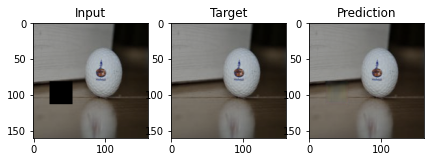

In [138]:
show_results(learn,figsize=(7,7))

MSE: 14.041763685982845
PSNR: 12.591185205757235


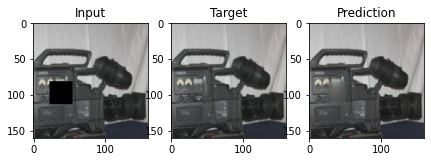

In [150]:
show_results(learn,figsize=(7,7))

MSE: 8.40135142187319
PSNR: 14.821910291512612


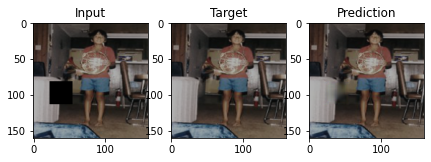

In [157]:
show_results(learn,figsize=(7,7))

MSE: 23.84915780487452
PSNR: 10.29067133206826


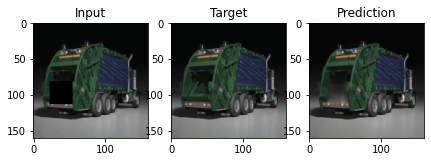

In [175]:
show_results(learn,figsize=(7,7))

MSE: 43.25915379244578
PSNR: 7.704621606352226


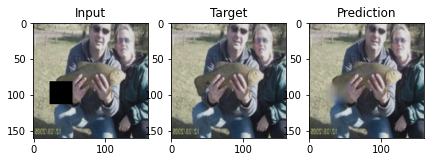

In [188]:
show_results(learn,figsize=(7,7))